# K-Means Clustering and Principal Component Analysis

This notebook implements the seventh exercise from Andrew Ng’s Machine Learning Course on Coursera.

K-means clustering and PCA are both examples of unsupervised learning techniques. Unsupervised learning problems do not have any target for us to learn from, to make predictions, so unsupervised algorithms instead attempts to find a structure in the data itself. 

In this notebook, we will first implement K-means and see how it can be used it to compress an image and then experiment with PCA to find a low-dimensional representation of images of faces.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [2]:
sn.set_style('whitegrid')
import scipy.io as sio

## K Means Clustering

K-means is an iterative, unsupervised clustering algorithm that groups similar instances together into clusters. The algorithm starts by guessing the initial centroids for each cluster, and then repeatedly assigns instances to the nearest cluster and re-computes the centroid of that cluster.

Let's apply K-means to image compression. The intuition here is that we can use clustering to find a small number of colors that are most representative of the image, and map the original 24-bit colors to a lower-dimensional color space using the cluster assignments.

### Loading the Dataset

(-0.5, 127.5, 127.5, -0.5)

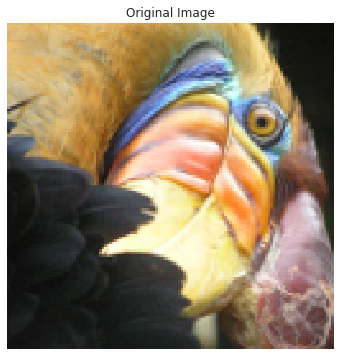

In [3]:
image_data = sio.loadmat('Data/bird_small.mat')

#let's plot it out
plt.figure(figsize = (8,6))
plt.imshow(image_data.get('A'))
plt.title('Original Image')
plt.axis('off')

### Data Preprocessing

Lets preprocess the data before applying K means algorithm

In [4]:
A = image_data['A']
A.shape

(128, 128, 3)

In [5]:
# normalize value ranges
A = A / 255.0

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))

### K Means Algorithm implementation

1. Initialize centroids
2. Cluster assignment step
3. Move centroid step

In [6]:
def init_centroids(X, k):
    """
    This function returns initializes centroid to 
    same location as a randomly chosen input!
    """
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

def find_closest_centroids(X, centroids):
    """
    Assign data to the cluster of nearest centroid 
    """
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = np.inf
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

def compute_centroids(X, idx, k):
    """
    compute mean of all data points in the cluster and 
    assign the centroid to that location
    """
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

def run_k_means(X, initial_centroids, max_iters):
    """
    putting it all together! and iterate until convergence.
    """
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

### K Means execution

In [7]:
# randomly initialize the centroids
initial_centroids = init_centroids(X, 16)

In [8]:
# run the algorithm
idx, centroids = run_k_means(X, initial_centroids, 10)

In [9]:
centroids

array([[0.96865936, 0.8718647 , 0.65946885],
       [0.56631801, 0.47683651, 0.42394711],
       [0.63512035, 0.46265822, 0.20533539],
       [0.51099375, 0.62596977, 0.79759607],
       [0.43258971, 0.33296602, 0.25006932],
       [0.06727257, 0.07309602, 0.06283486],
       [0.97470288, 0.95322435, 0.83486935],
       [0.14680729, 0.15308123, 0.14531813],
       [0.23005798, 0.23141238, 0.23831275],
       [0.34503496, 0.38495505, 0.49254061],
       [0.87691254, 0.72459717, 0.46172645],
       [0.8040129 , 0.74661643, 0.74675343],
       [0.32034314, 0.22252568, 0.15894024],
       [0.82447265, 0.59322445, 0.29516704],
       [0.70845771, 0.62274097, 0.51134638],
       [0.0971785 , 0.10494427, 0.09449723]])

In [10]:
# get the closest centroids one last time
idx = find_closest_centroids(X, centroids)

# map each pixel to the centroid value
X_recovered = centroids[idx.astype(int),:]

In [11]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))

(-0.5, 127.5, 127.5, -0.5)

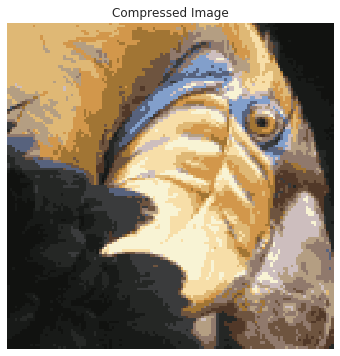

In [12]:
#let's plot it out
plt.figure(figsize = (8,6))
plt.imshow(X_recovered)
plt.title('Compressed Image')
plt.axis('off')

Thats it! We have found a small subset of colors to represent the original image using K-Means.

## Principal Component Analysis

PCA is a linear transformation that finds the "principal components", or directions of greatest variance, in a data set. It can be used for dimension reduction among other things. 
In this exercise, we will apply PCA to images of faces. By using the dimension reduction techniques we can capture the "essence" of the images using much less data than the original images.

### Loading the Dataset

In [13]:
faces = sio.loadmat('Data/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

(-0.5, 31.5, 31.5, -0.5)

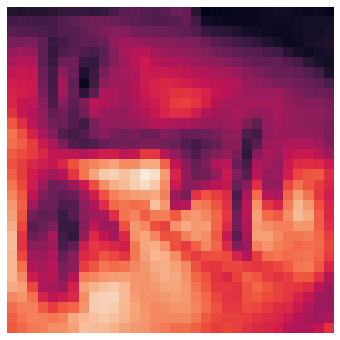

In [14]:
# Displaying a single face
plt.figure(figsize = (10,6))
plt.imshow(X[50,:].reshape(32,32))
plt.axis('off')

Since the feature vector is of length 1024, let's apply PCA and get only 100 principal components as the new feature vector!

### PCA Implementation and Execution

1. Feature normalization
2. Compute covariance matrix
3. Perform singular value decomposition

In [15]:
def pca(X):
    """
    Computes the principal components of the feature
    """
    # normalize the features
    X = (X - X.mean()) / X.std()
    
    # compute the covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    
    # perform SVD
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

In [16]:
# Applying PCA

U, S, V = pca(X)

U

matrix([[-0.01640988, -0.04222849, -0.0421747 , ...,  0.00078787,
          0.00059301,  0.00069988],
        [-0.01692408, -0.04109658, -0.04413594, ..., -0.0014743 ,
         -0.00159743, -0.00183183],
        [-0.01714767, -0.03963341, -0.04577663, ...,  0.00796443,
          0.00053733,  0.00152458],
        ...,
        [-0.0085838 , -0.05826306,  0.04851035, ..., -0.00294466,
          0.00394326,  0.00497121],
        [-0.00680308, -0.06081527,  0.04664601, ...,  0.00038729,
         -0.00186067, -0.00185365],
        [-0.005765  , -0.06173977,  0.04483153, ...,  0.00228049,
          0.00058499,  0.00071138]])

Now that we have the principal components (matrix U), we can use it to project the original data onto a lower-dimensional space. Selects only the top K components, effectively reducing the number of dimensions.

In [17]:
# projecting data on lower dimensional space (from 1024 to 100)

U_reduced = U[:,:100] # get only the first 100 columns of U

Z = np.dot(X, U_reduced) # reduced feature

In [18]:
Z

matrix([[ 526.09608833,  734.37008142,  194.48322788, ...,  -19.27422565,
           -3.22314155,   20.93551538],
        [ 304.5906028 ,  493.0633805 , -162.10424193, ...,  -20.94839919,
           17.86358442,   -8.14045979],
        [-389.99893833,  600.20010851, -293.91694459, ...,  -27.86998851,
           48.74829475,   17.98452065],
        ...,
        [ 487.55926046,  430.86037345,  490.71749378, ...,  -31.76395627,
           23.77770829,   51.74592358],
        [1358.99575656,  402.85437502, -136.10305216, ...,  -10.45305753,
           -2.76084233,    2.96467067],
        [ 372.01599145,  360.59923883,  105.10564415, ...,  -48.29644614,
           -8.75071522,  -30.24094867]])

In [19]:
X.shape, Z.shape

((5000, 1024), (5000, 100))

### Reconstructing the original data

Now we can attempt to recover the original structure and render it again.

In [20]:
X_approx =  np.dot(Z, U_reduced.T)

In [21]:
X_approx.shape

(5000, 1024)

(-0.5, 31.5, 31.5, -0.5)

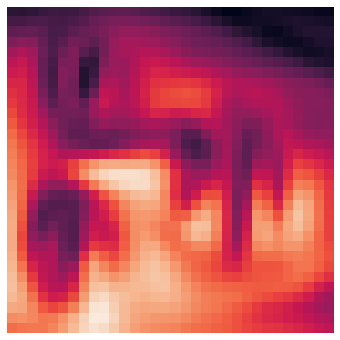

In [22]:
# lets plot this approximation
plt.figure(figsize = (10,6))
plt.imshow(X_approx[50,:].reshape(32,32))
plt.axis('off')

Thats it! PCA is effectively employed to reduce the computation complexity of many learning algorithms by reducing the dimensionality of the features but maintaining most variance.